In [7]:
import pandas as pd
from rdkit.Chem import AllChem as Chem
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import Descriptors
from rdkit import DataStructs
from __future__ import print_function
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import numpy as np
import pandas as pd
from rdkit import Chem
from rdkit.Chem import PandasTools
from rdkit.Chem.Draw import IPythonConsole
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
# MACCS Fingerprint
from rdkit.Chem import MACCSkeys
import moses
from tqdm.auto import tqdm
from random import sample
from rdkit.Chem import AllChem
from rdkit import Chem
from rdkit.Chem import Draw



from rdkit.Chem import DataStructs
from rdkit.ML.Cluster import Butina

In [24]:
# read the WHOLE DATASET
df_all = pd.read_csv('/home/mingyang/mma/transformer_code/split_data/CIL_metadata_all.csv')
df_all = df_all.sample(n=10000)
df_all

,compound,npy_path,smiles,fold,space_smiles,cluster
80933,BRD-K73082254-001-01-6,/gxr/Omics/CIL/26668-npy/26668_BRD-K73082254-0...,CCCNC(=O)N1C[C@@H](O)COC[C@H]2O[C@@H](CC(=O)N[...,3,C C C N C ( = O ) N 1 C [ C @ @ H ] ( O ) C O ...,cluster19
727279,BRD-K81627996-001-05-2,/gxr/Omics/CIL/25485-npy/25485_BRD-K81627996-0...,CCCCCC(=O)Nc1nc(C)c(s1)-c1csc(Nc2cc(Cl)ccc2OC)n1,0,C C C C C C ( = O ) N c 1 n c ( C ) c ( s 1 ) ...,cluster161
525034,BRD-A23970436-236-02-6,/gxr/Omics/CIL/24300-npy/24300_BRD-A23970436-2...,CCCC(C)C1(CC=C)C(=O)NC(S)=NC1=O,4,C C C C ( C ) C 1 ( C C = C ) C ( = O ) N C ( ...,cluster3049
17730,BRD-K64345025-001-02-4,/gxr/Omics/CIL/24751-npy/24751_BRD-K64345025-0...,C[C@@H](CO)N1C[C@H](C)[C@H](CN(C)S(=O)(=O)c2cc...,0,C [ C @ @ H ] ( C O ) N 1 C [ C @ H ] ( C ) [ ...,cluster6
161710,BRD-A41174898-001-05-5,/gxr/Omics/CIL/25664-npy/25664_BRD-A41174898-0...,Fc1ccc(cc1)-c1cc(C(=O)OCC(=O)NCC2CCCO2)c2ccccc2n1,4,F c 1 c c c ( c c 1 ) - c 1 c c ( C ( = O ) O ...,cluster787
...,...,...,...,...,...,...
620579,BRD-K42526449-001-01-6,/gxr/Omics/CIL/25931-npy/25931_BRD-K42526449-0...,COc1ccc(cc1)S(=O)(=O)N[C@H]1C=C[C@@H](CC(=O)N2...,1,C O c 1 c c c ( c c 1 ) S ( = O ) ( = O ) N [ ...,cluster25
744555,BRD-K64069148-001-05-5,/gxr/Omics/CIL/25564-npy/25564_BRD-K64069148-0...,Cn1cnnc1Sc1ccc(\C=C\C(=O)c2ccc(O)cc2)cc1[N+]([...,1,C n 1 c n n c 1 S c 1 c c c ( \ C = C \ C ( = ...,cluster1460
236718,BRD-K29950728-048-02-6,/gxr/Omics/CIL/25983-npy/25983_BRD-K29950728-0...,CCN(CC)CCOc1ccc(cc1)C(=C(/Cl)c1ccccc1)\c1ccccc1,0,C C N ( C C ) C C O c 1 c c c ( c c 1 ) C ( = ...,cluster763
363859,BRD-K60886324-001-01-1,/gxr/Omics/CIL/26626-npy/26626_BRD-K60886324-0...,COc1ccc(NC(=O)N[C@H]2CC[C@H](CCNC(=O)c3cc(Cl)c...,0,C O c 1 c c c ( N C ( = O ) N [ C @ H ] 2 C C ...,cluster12


In [25]:
### 我们已经在 CIL_metadata_all.csv数据全集中加入了 cluster列，代表着各自的cluster，现在只需要划分cluster并进行降维可视化验证即可

# 1. cluster
def ClusterFps(fps,cutoff=0.2):
    # first generate the distance matrix:
    dists = []
    nfps = len(fps)
    for i in tqdm(range(1,nfps)):
        sims = DataStructs.BulkTanimotoSimilarity(fps[i],fps[:i])
        dists.extend([1-x for x in sims])
    # now cluster the data:
    cs = Butina.ClusterData(dists,nfps,cutoff,isDistData=True)

    return cs

# GET MORGAN FPs
smiles_l = list(df_all['smiles'].unique())
mols_all =[]
print(len(smiles_l))
for smi in tqdm(smiles_l):
    m = Chem.MolFromSmiles(smi)
    mols_all.append(m)

fps_all = [AllChem.GetMorganFingerprintAsBitVect(x, 2) for x in tqdm(mols_all)]
print(len(fps_all))

# generate cluster (type: tuple)
cluster = ClusterFps(fps_all, cutoff=0.58)

# tuple to list
cluster_l = []
for child in cluster:
    cluster_l.append(list(child))

# list to dictionary
cluster_dict = {}
for i,child in enumerate(cluster_l):
    cluster_dict['cluster'+ str(i)] = child

### 我们已经在 CIL_metadata_all.csv数据全集中加入了 cluster列，代表着各自的cluster，现在只需要划分cluster并进行降维可视化验证即可
### 无需进行下一步
'''
# generate Dictionary of SMILES -> cluster_id
dict_smiles_to_cluster = {}
for i,smi in enumerate(tqdm(smiles_l)):
    for cluster_id in cluster_dict:
        if i in cluster_dict[cluster_id]:
            dict_smiles_to_cluster[smi] = cluster_id
            break
'''


8448



8448


'\n# generate Dictionary of SMILES -> cluster_id\ndict_smiles_to_cluster = {}\nfor i,smi in enumerate(tqdm(smiles_l)):\n    for cluster_id in cluster_dict:\n        if i in cluster_dict[cluster_id]:\n            dict_smiles_to_cluster[smi] = cluster_id\n            break\n'

In [70]:
# This is a sorted list from MOST num of molecules to LEAST num of molecules
cluster_ids_sorted = sorted(cluster_dict, key=lambda k: len(cluster_dict[k]), reverse=True)
#print(cluster_ids_sorted[:10])
print('Number of clusters:', len(cluster_ids_sorted))

# split Training and Test dataset
cid_test = cluster_ids_sorted[:30]
df_test = df_all[df_all['cluster'].isin(cid_test)]
df_train = df_all[~df_all['cluster'].isin(cid_test)]

Number of clusters: 2565


In [71]:
# check Number of molecules of df_train and df_test, should be 8:2
print(df_train.shape)
print(df_test.shape)
print(df_train.shape[0]/df_test.shape[0])

(5858, 6)
(4142, 6)
1.4142926122646065


In [72]:
# check & filter smiles token 目前模型设定的smiles长度阈值为95，以后可能会增加到120左右？
def filter_by_smiles_length(df_temp, smiles_limit:int):
    max_l = 0
    smiles_len_l = []
    for smiles in list(df_temp['smiles']):
        if len(smiles) > max_l:
            max_l = len(smiles)
        smiles_len_l.append(len(smiles))
    print('max_length:', max_l)

    df_temp['smiles_len'] = smiles_len_l

    return df_temp[df_temp['smiles_len'] < smiles_limit]

df_test = filter_by_smiles_length(df_test, 95)
df_train = filter_by_smiles_length(df_train, 95)

max_length: 123
max_length: 225


<ipython-input-72-cc8f44559751>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['smiles_len'] = smiles_len_l
<ipython-input-72-cc8f44559751>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['smiles_len'] = smiles_len_l


4797



3590



4797
3590
finished


<AxesSubplot:xlabel='PCA_C1', ylabel='PCA_C2'>

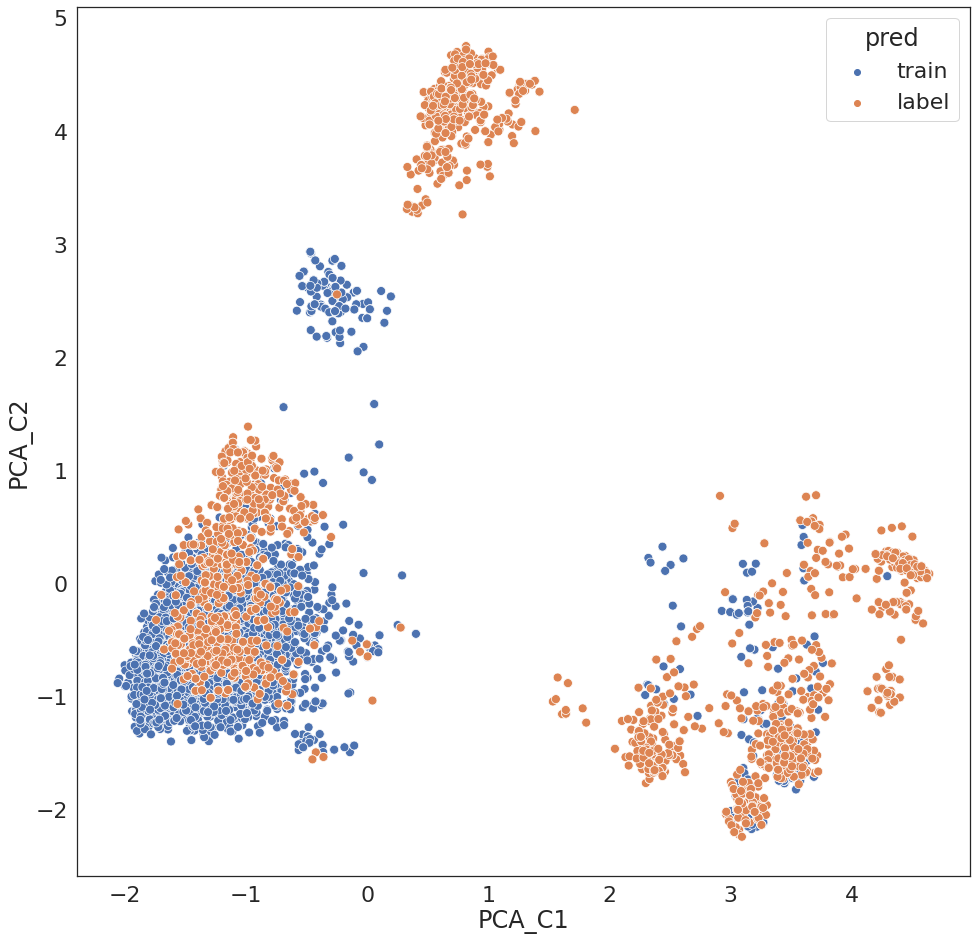

In [73]:
# 快速画图验证
# 1. generate fingerprints

def generate_morgan_fplist(df, sample_data = 0):
    mols =[]
    l = list(df['smiles'].unique())
    if sample_data > 0:
        l = sample(l, sample_data)
    print(len(l))
    for smi in tqdm(l):
        m = Chem.MolFromSmiles(smi)
        mols.append(m)

    fps = [AllChem.GetMorganFingerprintAsBitVect(x, 2) for x in tqdm(mols)]
    return fps


fps_train = generate_morgan_fplist(df_train)
fps_label = generate_morgan_fplist(df_test)
print(len(fps_train))
print(len(fps_label))

# 2. 画pca图
X_train = np.array(fps_train)
X_label = np.array(fps_label)
X_all = np.concatenate((X_train,X_label), axis=0)
pca_model = PCA(n_components=10, random_state=0)
tsne_pca_drugs_all = pca_model.fit_transform(X_all)
print('finished')

df_all_plot = pd.DataFrame(tsne_pca_drugs_all.T[0])
df_all_plot['PCA_C1'] = tsne_pca_drugs_all.T[0]
df_all_plot['PCA_C2'] = tsne_pca_drugs_all.T[1]

pred_class = ['train'] * len(fps_train) + ['label'] * len(fps_label)
df_all_plot['pred'] = pred_class

# use df_all_plot to plot PCA
plt.figure(figsize=(16, 16))
sns.set(font_scale=2) 
sns.set_style("white")
sns.scatterplot(data=df_all_plot, x="PCA_C1", y="PCA_C2"#, palette='viridis'
                , hue = 'pred', s=80)



In [ ]:
# Last modification： For training data, we will Randomnized the SMILES string
from rdkit import Chem
smi_l = list(df_train['smiles'])
smi_l_random = []
for smi in tqdm(smi_l):
    try:
        smi_l_random.append(Chem.MolToSmiles(Chem.MolFromSmiles(smi), doRandom=True))       
    except:
        #print('error parsing smiles')
        smi_l_random.append(smi)
        
df_train['smiles_org'] = list(df_train['smiles'])
df_train['smiles'] = smi_l_random
print(df_train['smiles'].unique().shape)
print(df_train['smiles_org'].unique().shape)

# modify space smiles
new_smiles = []
for i in df_train['smiles']:
    new_s = " ".join(i)
    new_smiles.append(new_s)
df_train['space_smiles'] = new_smiles
df_train


In [ ]:
# save files
df_train.to_csv('split_data/trainset_by_cluster.csv', index = False)
df_test.to_csv('split_data/testset_by_cluster.csv', index = False)